In [146]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [147]:
df = pd.read_csv("episode_info.csv")

# Drop duplicate index column
df.drop(["Unnamed: 0"], axis=1, inplace=True)

print("Rows: {}\nColumns: {}".format(df.shape[0], df.shape[1]))
df.head(n=5)

Rows: 174
Columns: 7


,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
0,1.0,1.0,"Good News, Bad News","July 5, 1989","Larry David, Jerry Seinfeld",Art Wolff,S01E01
1,1.0,1.0,The Stakeout,"May 31, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E01
2,1.0,2.0,The Robbery,"June 7, 1990",Matt Goldman,Tom Cherones,S01E02
3,1.0,3.0,Male Unbonding,"June 14, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E03
4,1.0,4.0,The Stock Tip,"June 21, 1990","Larry David, Jerry Seinfeld",Tom Cherones,S01E04


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 7 columns):
Season       174 non-null float64
EpisodeNo    174 non-null float64
Title        174 non-null object
AirDate      174 non-null object
Writers      174 non-null object
Director     174 non-null object
SEID         174 non-null object
dtypes: float64(2), object(5)
memory usage: 9.6+ KB


In [30]:
def convert_to_category(df, cols):
    for col in cols:
        df[col] = df[col].astype("category")

In [149]:
convert_to_category(df, ["Writers", "Director", "SEID"])

In [150]:
df["AirDate"] = pd.to_datetime(df["AirDate"])

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 7 columns):
Season       174 non-null float64
EpisodeNo    174 non-null float64
Title        174 non-null object
AirDate      174 non-null datetime64[ns]
Writers      174 non-null category
Director     174 non-null category
SEID         174 non-null category
dtypes: category(3), datetime64[ns](1), float64(2), object(1)
memory usage: 15.8+ KB


In [152]:
df.head()

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
0,1.0,1.0,"Good News, Bad News",1989-07-05,"Larry David, Jerry Seinfeld",Art Wolff,S01E01
1,1.0,1.0,The Stakeout,1990-05-31,"Larry David, Jerry Seinfeld",Tom Cherones,S01E01
2,1.0,2.0,The Robbery,1990-06-07,Matt Goldman,Tom Cherones,S01E02
3,1.0,3.0,Male Unbonding,1990-06-14,"Larry David, Jerry Seinfeld",Tom Cherones,S01E03
4,1.0,4.0,The Stock Tip,1990-06-21,"Larry David, Jerry Seinfeld",Tom Cherones,S01E04


In [153]:
def down_2_int(df, cols):
    for col in cols:
        df[col] = df[col].astype(int)

In [154]:
down_2_int(df, ["Season", "EpisodeNo"])

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 7 columns):
Season       174 non-null int64
EpisodeNo    174 non-null int64
Title        174 non-null object
AirDate      174 non-null datetime64[ns]
Writers      174 non-null category
Director     174 non-null category
SEID         174 non-null category
dtypes: category(3), datetime64[ns](1), int64(2), object(1)
memory usage: 15.8+ KB


In [156]:
df.isnull().sum()

Season       0
EpisodeNo    0
Title        0
AirDate      0
Writers      0
Director     0
SEID         0
dtype: int64

In [157]:
# Helper function to find unique column values
def unique_col_values(df):
    max_name_len = np.max([len(col_name) for col_name in df.columns]) + 2
    format_str = "{:<" + str(max_name_len) + "}{:<8}{:<15}"

    print(format_str.format("Name", "Unique", "DType"))
    print()
    for col in df:
        print(format_str.format(df[col].name, len(df[col].unique()), str(df[col].dtype)))

In [158]:
unique_col_values(df)

Name       Unique  DType          

Season     9       int64          
EpisodeNo  24      int64          
Title      174     object         
AirDate    169     datetime64[ns] 
Writers    52      category       
Director   8       category       
SEID       173     category       


Duplicates are expected for Season, EpisodeNo, Writers, and Director. AirDate and SEID, however, duplicates are not expected. Let's see what's going on:

In [159]:
df[df.duplicated("AirDate")]

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
34,3,18,The Boyfriend (2),1992-02-12,Larry David and Larry Levin,Tom Cherones,S03E18
43,4,4,The Ticket,1992-09-16,Larry David,Tom Cherones,S04E04
63,4,24,The Pilot (2),1993-05-20,Larry David,Tom Cherones,S04E24
121,7,15,The Cadillac (2),1996-02-08,"Larry David, Jerry Seinfeld",Andy Ackerman,S07E15
128,7,22,The Bottle Deposit (2),1996-05-02,"Gregg Kavet, Andy Robin",Andy Ackerman,S07E22


In [160]:
df.iloc[42:44,]

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
42,4,3,The Pitch,1992-09-16,Larry Charles,Tom Cherones,S04E03
43,4,4,The Ticket,1992-09-16,Larry David,Tom Cherones,S04E04


Per Wikipedia, "The Pitch", and "The Ticket" was a two-part series that aired on the same night. All the rest appear to be two-parters as well. Thus, no problem.

In [161]:
df[df.duplicated("SEID")]

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
1,1,1,The Stakeout,1990-05-31,"Larry David, Jerry Seinfeld",Tom Cherones,S01E01


In [162]:
df.iloc[0:2]

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID
0,1,1,"Good News, Bad News",1989-07-05,"Larry David, Jerry Seinfeld",Art Wolff,S01E01
1,1,1,The Stakeout,1990-05-31,"Larry David, Jerry Seinfeld",Tom Cherones,S01E01


This looks to be an actual mistake. "Good News, Bad News" should be episode one, while "The Stakeout" should be episode two. No corrective action will be taken right now, but we note the error as it may need to be fixed later.

In [163]:
for writer in df["Writers"].unique():
    print(writer)
    print()

Larry David, Jerry Seinfeld

Matt Goldman

Peter Mehlman

Larry David

Larry Charles

Elaine Pope

Tom Leopold

Larry David and Bob Shaw, Don McEnery

Larry David, Jerry Seinfeld and Matt Goldman

Larry David and Bill Masters

Elaine Pope, Larry Charles

Larry David and Larry Levin

Larry Charles / Story By Marc Jaffe

Larry David and Greg Daniels

Larry David, Larry Charles

Steve Skrovan, Bill Masters, Jon Hayman

Bruce Kirschbaum

Andy Robin

Larry David, Peter Mehlman

Lawrence H. Levy, Buck Dancer (Larry David pseudonym)

Tom Gammill, Max Pross

Carol Leifer

Ron Hague, Charlie Rubin

Tom Gammill, Max Pross and Larry David, Jerry Seinfeld

Peter Mehlman, Carol Leifer

Andy Cowan and Larry David, Jerry Seinfeld

Larry David, Bill Masters, Bob Shaw

Alec Berg, Jeff Schaffer

Fred Stoller

Carol Leifer, Marjorie Gross

Tom Gammill, Max Pross and Larry David

Bruce Kirschbaum and Sam Kass

Gregg Kavet, Andy Robin

Marjorie Gross

Marjorie Gross, Carol Leifer

Spike Feresten

David Man

In [164]:
top_20_writing_teams = df["Writers"].value_counts().head(20)
top_20_index = list(top_20_writing_teams.index)
top_20_values = list(top_20_writing_teams.values)

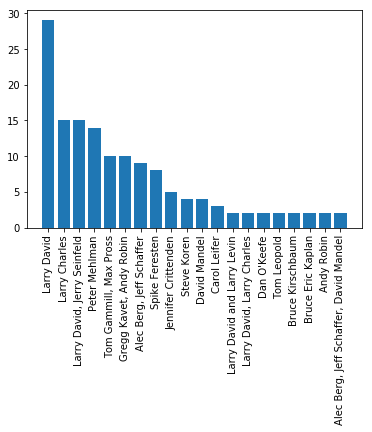

In [165]:
plt.bar(x=top_20_index, height=top_20_values)
plt.xticks(rotation=90)
plt.show()

In [166]:
total_larry_david = len([writer for writer in df["Writers"].unique() if "Larry David" in writer])
total_larry_david

14

In [167]:
def writer_counter(writer_name):
    count = 0
    for writer in df["Writers"]:
        if writer_name in writer:
            count += 1
    return count

In [168]:
writer_list = ["Larry David", "Larry Charles", "Jerry Seinfeld", "Peter Mehlman", "Tom Gammill", "Max Pross",
              "Alec Berg", "Gregg Kavet", "Andy Robin", "Jeff Schaffer", "Spike Feresten", "Jennifer Crittenden",
              "Steve Koren", "David Mandel", "Carol Leifer", "Larry Levin"]

for writer in writer_list:
    print("{} wrote/co-wrote total: {}".format(writer, writer_counter(writer)))

Larry David wrote/co-wrote total: 58
Larry Charles wrote/co-wrote total: 19
Jerry Seinfeld wrote/co-wrote total: 18
Peter Mehlman wrote/co-wrote total: 19
Tom Gammill wrote/co-wrote total: 13
Max Pross wrote/co-wrote total: 13
Alec Berg wrote/co-wrote total: 14
Gregg Kavet wrote/co-wrote total: 11
Andy Robin wrote/co-wrote total: 13
Jeff Schaffer wrote/co-wrote total: 14
Spike Feresten wrote/co-wrote total: 9
Jennifer Crittenden wrote/co-wrote total: 6
Steve Koren wrote/co-wrote total: 5
David Mandel wrote/co-wrote total: 9
Carol Leifer wrote/co-wrote total: 6
Larry Levin wrote/co-wrote total: 2


Larry David left the biggest mark on the show, being credit as a writer (solo or team) on a total of 58 episodes. Interestingly, Jerry Seinfeld only contributed as a writer for 18 episodes (although, this shouldn't surprise anyone who has seen Larry David's other show, "Curb Your Enthusiasm").

In [169]:
df["Director"].value_counts()

Andy Ackerman            87
Tom Cherones             80
David Owen Trainor        2
Joshua White              1
Jason Alexander           1
David&nbsp; Steinberg     1
David Steinberg           1
Art Wolff                 1
Name: Director, dtype: int64

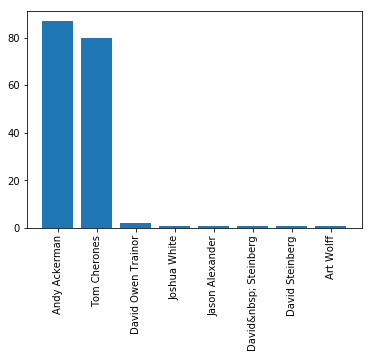

In [170]:
plt.bar(x=df["Director"].value_counts().index,
        height=df["Director"].value_counts().values)
plt.xticks(rotation=90)
plt.show()

In [171]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = stopwords.words("english")


def preprocess_text(text):
    # Remove text and tokenize
    text = str(text)
    regex_pattern = r"(\w[\w']*\w|\w)"
    regex_compiled = re.compile(regex_pattern)
    tokens = regex_compiled.findall(text)
    
    # Convert to lowercase
    tokens = [word.lower() for word in tokens]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Stem
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]
    
    return tokens

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(analyzer=preprocess_text)
bow.fit(X)


CountVectorizer(analyzer=<function preprocess_text at 0x1a20a051e0>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [137]:
title_bow = bow.transform(X)
print(title_bow.shape)

(174, 231)


In [138]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = TfidfTransformer()
title_tfidf = tfidf_transformer.fit(title_bow)

In [139]:
#count = TfidfVectorizer(stop_words="english", max_df=0.1, max_features=5000)
#X = count.fit_transform(X)

In [140]:
lda = LatentDirichletAllocation(n_topics=20, random_state=42, learning_method="batch")
X_topics = lda.fit_transform(title_bow)

In [141]:
n_top_words = 5
feature_names = bow.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic {}:".format(topic_idx + 1))
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 1:
andrea pez diplomat' dispens doria
Topic 2:
pilot chicken head roaster seren
Topic 3:
store mom pop amp day
Topic 4:
1 wallet biologist marin fix
Topic 5:
1 bottl deposit boy buren
Topic 6:
news letter good littl bad
Topic 7:
trip lip mail tub hot
Topic 8:
chines park samaritan puffi woman
Topic 9:
yada merv show griffin unbond
Topic 10:
shower babi georg summer chaperon
Topic 11:
parti dinner dot wig red
Topic 12:
man k peephol fur revers
Topic 13:
soup code stock nazi account
Topic 14:
hello kiss restaur bubbl pledg
Topic 15:
butter shave spot maker label
Topic 16:
boyfriend old muffin top stand
Topic 17:
car altern side smelli movi
Topic 18:
2 club cadillac gypsi friar
Topic 19:
glass opera tape couch pie
Topic 20:
jerri yogurt non fat ex


In [142]:
df2 = pd.read_csv("scripts.csv")
df2.head(n=10)

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
0,0,JERRY,Do you know what this is all about? Do you kno...,1.0,S01E01,1.0
1,1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1.0,S01E01,1.0
2,2,GEORGE,Are you through?,1.0,S01E01,1.0
3,3,JERRY,"You do of course try on, when you buy?",1.0,S01E01,1.0
4,4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",1.0,S01E01,1.0
5,5,JERRY,"Oh, you dont recall?",1.0,S01E01,1.0
6,6,GEORGE,"(on an imaginary microphone) Uh, no, not at th...",1.0,S01E01,1.0
7,7,JERRY,"Well, senator, Id just like to know, what you ...",1.0,S01E01,1.0
8,8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,1.0,S01E01,1.0
9,9,GEORGE,"Are, are you sure this is decaf? Wheres the or...",1.0,S01E01,1.0


In [143]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54616 entries, 0 to 54615
Data columns (total 6 columns):
Unnamed: 0    54616 non-null int64
Character     54616 non-null object
Dialogue      54606 non-null object
EpisodeNo     54616 non-null float64
SEID          54616 non-null object
Season        54616 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.5+ MB


In [144]:
df2.isnull().sum()

Unnamed: 0     0
Character      0
Dialogue      10
EpisodeNo      0
SEID           0
Season         0
dtype: int64